In [1]:
from os.path import basename
from glob import glob
from pandas import DataFrame, read_csv, concat
from dtale import show

In [10]:
BIBLES = ["asv", "fbv", "kjv", "web", "wmb"]
LABELS = ["pos", "neg", "neu"]
NAMES = ["olivia", "river", "gerardo", "nick", "cameron"]

## Compiling everyone's data
Each person has a folder with their sentiment annotations of 5 different bible translations.

The following cell takes everyone's annotations and puts them in one dataframe as\
`bible, chunk, name1, name2, `

In [3]:
# go through a person's folder and compile the labels into one dataframe for that person
def compile_labels(name) -> DataFrame:
    frames = []

    # get the annotator's files
    files = sorted(glob(f"../manual_annotation/{name}/*.csv"))

    for f in files:
        # read the csv, only keep sentiment column and chunk as index
        df = DataFrame(read_csv(f, index_col="chunk"), columns=["sentiment"])
        frames.append(df)

    # combine the dataframes, index by bible and chunk
    compiled = concat(frames, keys=BIBLES, names=["bible", "chunk"])

    return compiled


# combine all the annotators into one dataframe
def compile() -> DataFrame:

    # compile the labels of each annotator
    annotator_frames = [compile_labels(name) for name in NAMES]

    # new dataframe with only index (bible, chunk)
    df = DataFrame(index=annotator_frames[0].index)

    # add a column for each annotator
    for name, frame in zip(NAMES, annotator_frames):
        df[name] = frame["sentiment"]

    return df

In [4]:
compiled = compile()
compiled

olivia  river  gerardo  nick  cameron
bible chunk                                       
asv   2556        3      2        1     3        3
      10127       3      3        3     3        3
      9900        2      2        1     2        2
      3951        2      2        3     2        2
      3840        3      3        3     3        1
...             ...    ...      ...   ...      ...
wmb   4236        3      3        1     3        3
      5307        3      3        3     3        3
      9942        3      2        2     1        1
      4226        3      3        1     3        3
      9476        1      2        1     1        2

[90 rows x 5 columns]

## Analysis

### Fleiss' kappa

$k=\dfrac{p_o - p_e}{1 - p_e}$

$p_e =$ expected agreement if random\
$p_o =$ observed agreement


In [5]:
# count number of annotators that chose each label
def label_counts(df: DataFrame) -> DataFrame:
    counts = {"pos": [], "neg": [], "neu": []}

    # count
    for i, row in df.iterrows():
        vals = list(row.values)
        counts["neu"].append(vals.count(1))
        counts["pos"].append(vals.count(2))
        counts["neg"].append(vals.count(3))

    # make a df with the counts
    return DataFrame(counts, index=df.index)

In [6]:
counted = label_counts(compiled)
counted

pos  neg  neu
bible chunk               
asv   2556     1    3    1
      10127    0    5    0
      9900     4    0    1
      3951     4    1    0
      3840     0    4    1
...          ...  ...  ...
wmb   4236     0    4    1
      5307     0    5    0
      9942     2    1    2
      4226     0    4    1
      9476     2    0    3

[90 rows x 3 columns]

In [7]:
# essentially agreement per sample
def add_P_i(df: DataFrame) -> DataFrame:
    p_i_list = []

    # number of annotators
    n = len(NAMES)

    # get p for each row
    for i, row in df.iterrows():

        # observed agreement
        denom = n * (n - 1)
        numer = sum(n_ij**2 for n_ij in row[LABELS]) - n
        p = numer / denom

        # save value for the row
        p_i_list.append(p)

    # add column to dataframe
    df["P_i"] = p_i_list
    return df


# fleiss' kappa
def fleiss(df: DataFrame) -> float:
    # mean observed agreement
    P_o = df["P_i"].mean()

    # agreement per label
    total_labels = df[LABELS].sum().sum()
    P_j = [df[label].sum() / total_labels for label in LABELS]

    # expected agreement if random
    P_e = sum(p**2 for p in P_j)

    # fleiss kappa
    k = (P_o - P_e) / (1 - P_e)

    return k

In [8]:
df = add_P_i(counted)
print(f"Fleiss's kappa = {fleiss(df):.3f}")
show(df)

Fleiss's kappa = 0.435


In [36]:
df

pos  neg  neu  P_i
bible chunk                    
asv   2556     1    3    1  0.3
      10127    0    5    0  1.0
      9900     4    0    1  0.6
      3951     4    1    0  0.6
      3840     0    4    1  0.6
...          ...  ...  ...  ...
wmb   4236     0    4    1  0.6
      5307     0    5    0  1.0
      9942     2    1    2  0.2
      4226     0    4    1  0.6
      9476     2    0    3  0.4

[90 rows x 4 columns]

### Analysis per bible

In [35]:
# get kappa for each bible
def get_agreement_distribution(df: DataFrame) -> dict:
    agreements = {"5": 0, "4": 0, "3-2": 0, "3-1-1": 0, "2-2-1": 0}

    for i, row in df.iterrows():
        vals = list(row[LABELS])

        if 5 in vals:
            agreements["5"] += 1
        elif 4 in vals:
            agreements["4"] += 1
        elif 3 in vals and 2 in vals:
            agreements["3-2"] += 1
        elif 3 in vals and 1 in vals:
            agreements["3-1-1"] += 1
        elif 2 in vals and 1 in vals:
            agreements["2-2-1"] += 1

    for k, v in agreements.items():
        agreements[k] = v / len(df)

    return agreements


def get_data_per_bible(df: DataFrame) -> DataFrame:
    kappas = []
    agreement_types = {
        "5": [],
        "4": [],
        "3-2": [],
        "3-1-1": [],
        "2-2-1": [],
    }

    for bible in BIBLES:
        bible_df = df.loc[bible]

        # get fleiss' kappa
        k = fleiss(bible_df)
        kappas.append(k)

        # get agreement types
        vals = get_agreement_distribution(bible_df)
        for key, val in vals.items():
            agreement_types[key].append(val)

    # make a dataframe
    df = DataFrame(agreement_types, index=BIBLES)
    df.index.name = "bible"

    # add Fleiss' kappa column
    df["kappa"] = [f"{k:.3f}" for k in kappas]

    # reorder the columns
    return df[["kappa", "5", "4", "3-2", "3-1-1", "2-2-1"]]


ag = get_data_per_bible(df)
ag.to_csv("translation_agreement.csv")
ag

,kappa,5,4,3-2,3-1-1,2-2-1
bible,,,,,,
asv,0.200,0.10,0.50,0.20,0.20,0.00
fbv,0.621,0.50,0.30,0.10,0.10,0.00
kjv,0.397,0.26,0.32,0.26,0.12,0.04
web,0.533,0.30,0.60,0.10,0.00,0.00
wmb,0.439,0.30,0.40,0.10,0.10,0.10


### Plot Results

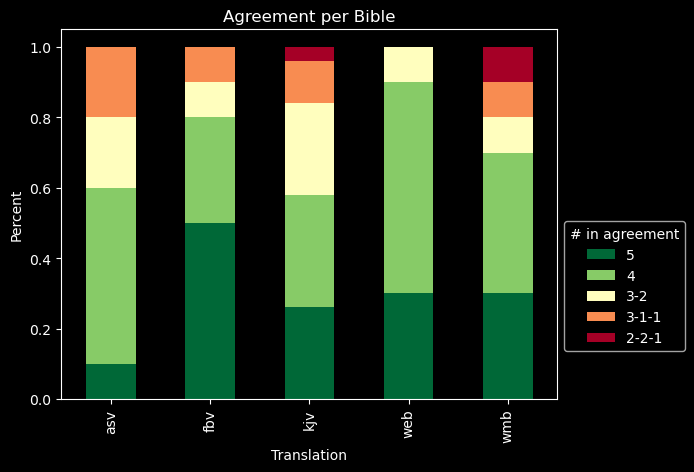

In [34]:
p = ag.plot(kind="bar", stacked=True, title="Agreement per Bible", colormap="RdYlGn_r")
p.set_ylabel("Percent")
p.set_xlabel("Translation")
leg = p.legend(title="# in agreement", bbox_to_anchor=(1, 0.5))